In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
from skimage import io, color
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class FaceDataset(Dataset):
    def __init__(self, image_dir, label_dir, group_id, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.group_id = group_id
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_filenames[idx])
        image = io.imread(img_name)
        image = color.rgb2gray(image)  # Convert to grayscale
        image = image.flatten()  # Reshape to 1D vector

        image = image[:101*101]

        
        label_name = os.path.join(self.label_dir, self.image_filenames[idx].replace('.jpg', '.att'))
        labels = np.loadtxt(label_name)
        label = int(labels[self.group_id - 1])  # Get the label for the assigned task
        
        if self.transform:
            image = self.transform(image)
        
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

def plot_loss(loss_history, title):
    plt.plot(loss_history)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return self.sigmoid(x)

class MLP_PCA(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP_PCA, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return self.sigmoid(x)

def train_mlp_batch(model, train_loader, val_loader, n_epochs=100, lr=0.001):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    loss_history = []
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        for batch_idx, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            images=images.to(device)
            labels=labels.to(device)

            outputs = model(images)
            labels = labels.view(-1, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}')
    
    return loss_history

def evaluate_model(model, test_loader, train_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images=images.to(device)
            labels=labels.to(device)
            outputs = model(images)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.view(-1) == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    with torch.no_grad():
        for images, labels in train_loader:
            images=images.to(device)
            labels=labels.to(device)
            outputs = model(images)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.view(-1) == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Train Accuracy: {accuracy:.2f}%')

def load_data(image_dir, test_dir, group_id, batch_size=1, test_size=0.2):
    train_dataset = FaceDataset(image_dir, image_dir, group_id)
    test_dataset = FaceDataset(test_dir, test_dir, group_id)

    return train_dataset,test_dataset


input_size = 101 * 101  # Image size (grayscale 101x101)
input_size_pca = 100 
hidden_size = 50  # Number of hidden neurons
n_epochs = 100  # Number of epochs
batch_size = 128  # Batch size
learning_rate = 0.001  # Learning rate
group_id = 1  

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)

image_dir = 'face/TrainImages'
test_dir = 'face/TestImages'

train_dataset, test_dataset = load_data(image_dir, test_dir, group_id, batch_size)

# model = MLP(input_size, hidden_size).to(device)
model = MLP_PCA(input_size_pca, hidden_size).to(device)


cuda


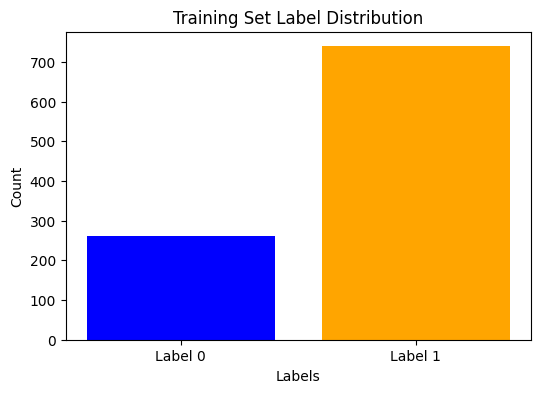

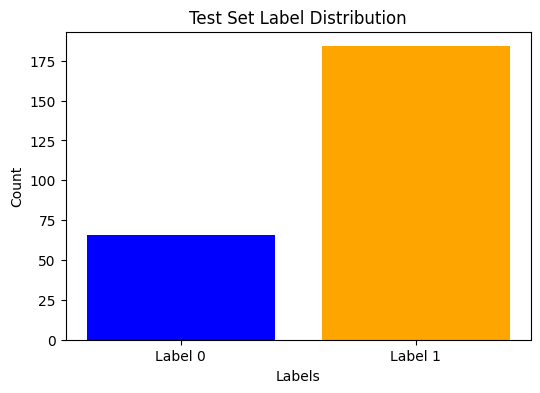

In [11]:
def plot_label_distribution(dataset, title="Label Distribution"):
    labels = [dataset[i][1].item() for i in range(len(dataset))]
    label_0_count = labels.count(0)
    label_1_count = labels.count(1)
    
    plt.figure(figsize=(6, 4))
    plt.bar(['Label 0', 'Label 1'], [label_0_count, label_1_count], color=['blue', 'orange'])
    plt.title(title)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.show()

plot_label_distribution(train_dataset, title="Training Set Label Distribution")
plot_label_distribution(test_dataset, title="Test Set Label Distribution")

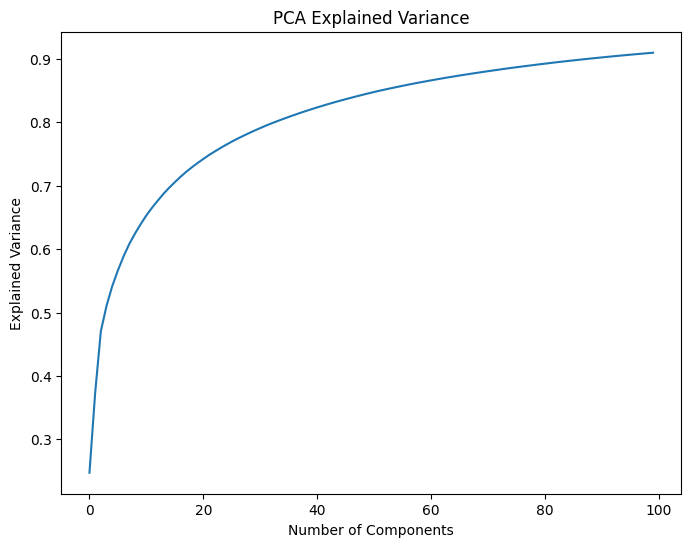

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Function to apply PCA on image dataset
def apply_pca(dataset, n_components):
    # Flatten the images and convert to a matrix
    images = np.array([dataset[i][0].numpy() for i in range(len(dataset))])
    
    # Standardize the data (important for PCA)
    scaler = StandardScaler()
    images_scaled = scaler.fit_transform(images)
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    images_pca = pca.fit_transform(images_scaled)
    
    # Reconstruct the dataset with reduced dimensions
    new_dataset = [(torch.tensor(images_pca[i], dtype=torch.float32), dataset[i][1]) for i in range(len(dataset))]
    
    return new_dataset, pca

# Example usage
n_components = 100  # Reduce to 100 dimensions
train_dataset_pca, pca_model = apply_pca(train_dataset, n_components)
test_dataset_pca, _ = apply_pca(test_dataset, n_components)

# Plot explained variance ratio to see how much variance is retained
def plot_explained_variance(pca_model):
    plt.figure(figsize=(8, 6))
    plt.plot(np.cumsum(pca_model.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance')
    plt.title('PCA Explained Variance')
    plt.show()

plot_explained_variance(pca_model)

In [13]:
train_loader_batch = DataLoader(train_dataset_pca, batch_size=len(train_dataset), shuffle=True)
train_loader_sequential = DataLoader(train_dataset_pca, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset_pca, batch_size=batch_size, shuffle=False)

Epoch [10/100], Loss: 0.1575
Epoch [20/100], Loss: 0.0642
Epoch [30/100], Loss: 0.0295
Epoch [40/100], Loss: 0.0162
Epoch [50/100], Loss: 0.0099
Epoch [60/100], Loss: 0.0067
Epoch [70/100], Loss: 0.0048
Epoch [80/100], Loss: 0.0036
Epoch [90/100], Loss: 0.0028
Epoch [100/100], Loss: 0.0023


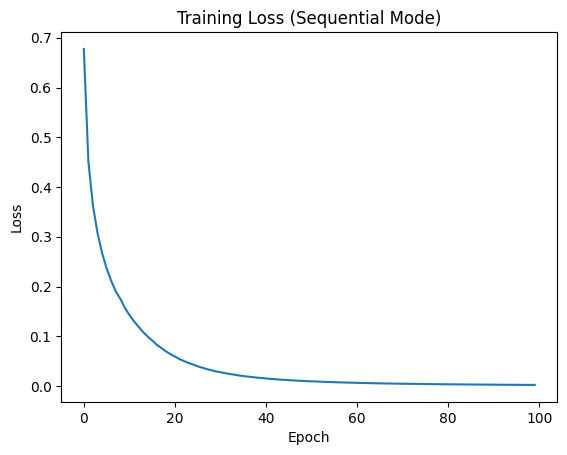

In [14]:
loss_history = train_mlp_batch(model, train_loader_batch, test_loader, n_epochs=300, lr=learning_rate)
plot_loss(loss_history, 'Training Loss (Batch Mode)')

In [15]:
evaluate_model(model, test_loader, train_loader_sequential)

Test Accuracy: 52.40%
Train Accuracy: 90.48%
